In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import emcee
from IPython.display import display, Math
import corner

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes




# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') 
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]

#includes falres that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [4]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

In [5]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

#plt.figure(figsize=(15,4))
#plt.plot(df['time'], df['detrended_flux'])
#plt.plot(df['time'], df['mean'])
#plt.show()

#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
#print(len(df))
detrended = df['detrended_flux'].values - df['mean'].values

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


In [6]:
#stacked_flare_vals=pd.read_csv('stacked_flare_values.csv')
new_stacked_flare_vals=pd.read_csv('new_stacked_flare_values.csv')

In [7]:
len(new_stacked_flare_vals['time'].values)

54385

(-5.0, 15.0)

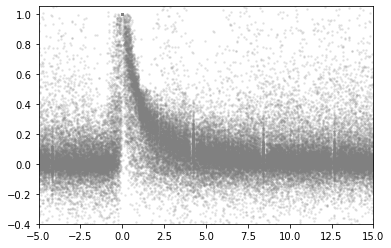

In [8]:
time = new_stacked_flare_vals['time'].values
flux = new_stacked_flare_vals['flux'].values
flux_err = new_stacked_flare_vals['flux_err'].values
gp_err = new_stacked_flare_vals['gp_st_dev'].values
ns_all = np.argsort(time)
plt.scatter(time[ns_all],flux[ns_all],alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.05)
plt.xlim(-5,15)

In [9]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

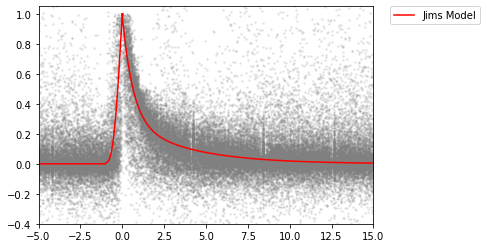

In [10]:
jim_model = aflare1(time,0,1,1)
plt.scatter(time[ns_all],flux[ns_all],alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.4,1.05)
plt.xlim(-5,15)
plt.plot(time[ns_all],aflare1(time[ns_all],0,1,1),color='red',label='Jims Model')        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [11]:
from scipy import special
def ModifiedGaussian(t,A,mu,sigma,tau):
        x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
        s = A*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
        return s
    
def jackman(t,A,B,C,D1,D2,f1):
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    f_t2 = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    return f_t2

### Now to fit our model
Jackman et al used 500 walkers for 2000 steps and discarded the first 500 as a burn-in

To start off we have to write down a likelihood function (or the probability of a dataset given the model parameters)

Text(0, 0.5, 'Relative Flux')

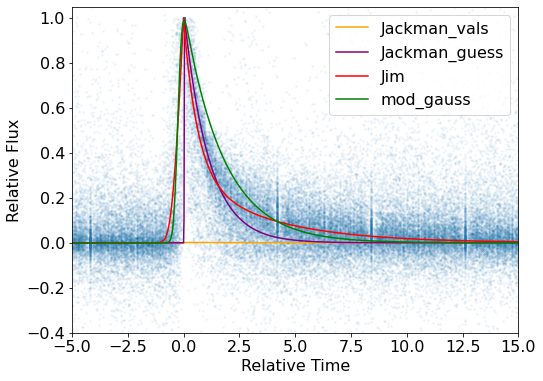

In [12]:
plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(time[ns_all],jackman(time,2.9, .057, .0003, .043, .7579, .52)[ns_all],label='Jackman_vals',color='orange')
plt.plot(time[ns_all],jackman(time,57,.03,.01,.9,.9,-2)[ns_all],label='Jackman_guess',color='purple')
plt.plot(time[ns_all],jim_model[ns_all],color='red',label='Jim')
#plt.plot(time[ns_all],ModifiedGaussian(time,1.54384986, -0.25071652, -0.1224898,1.79944)[ns_all],label='mod_gauss',color='green')
plt.plot(time[ns_all],ModifiedGaussian(time,2.1, -.25,-.15,1.75)[ns_all],label='mod_gauss',color='green')
plt.scatter(time[ns_all],flux[ns_all],alpha=0.05,s=10,marker='.')
#plt.xlim(-4,5)
plt.ylim(-0.4,1.05)
plt.xlim(-5,15)
plt.legend(loc='upper right')
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')

## Emcee Runs

In [35]:
#single_exp = ModifiedGaussian(time,3,0,.05,2.85)[s_all]
#double_exp= jackman(time,57,.03,.01,.9,.9,-2)[s_all]

#modified gaussian parameters
amp_i = 1.47596379 #2.1#1.54384986
mu_i =  -0.27286221  #-.25 #-0.25071652
sigma_i =  -0.18613402  #-.15 #-0.1224898
tau_i = 1.1825405 #1.75 #1.79944


#single_exp = ModifiedGaussian(time[ns_all],amp_i,mu_i,sigma_i,tau_i)
#double_exp= jackman(time[ns_all],A,B,C,D1,D2,f1)

### Running emcee on the single_exp model

In [63]:
def ModGaussModel(t,theta):
    amp,mu,sigma,tau = theta
    #theta = amp,mu,sigma,tau
    x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
    single_model = amp*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
    return single_model

In [64]:
test = amp_i,mu_i,sigma_i,tau_i
ModGaussModel(time,test)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.45527700e-06, 3.92369650e-06, 3.45554142e-06])

In [65]:
def lnlike(theta, time, flux, flux_err):
    amp,mu,sigma,tau = theta
    #model = ModifiedGaussian(time,*theta)
    model = ModGaussModel(time,theta)
    #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    lnlike = -0.5*(np.sum((flux-model)**2)) #*inv_sigma2 - np.log(inv_sigma2)))   #-chi squared
    return lnlike

In [76]:
lnlike(test,time,flux,flux_err)

-3366.0100296897053

In [85]:
#Don't need this since we are starting off with a flat prior
def lnprior(theta):
    amp,mu,sigma,tau = theta
    #if -5.0 < amp < 0.5 and 0.0 < mu < 10.0 and -10.0 < sigma < 1.0 and 0<tau<1:
    #if not np.sum(np.isfinite(theta)):
        #return 0.0
    return 0

In [86]:
lnprior(test)

0

In [87]:
def lnprob(theta, time, flux, flux_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, flux, flux_err)

In [88]:
lnprob(test,time,flux,flux_err)

-3366.0100296897053

In [89]:
#pos = soln.x + 1e-4 * np.random.randn(32, 3)
#0.17055418 -0.03995083 -0.05411289  0.05785364
# attempting new init_vals 2.1, -.25,-.15,1.75

initial = np.array([1.47596379, -0.27286221, -0.18613402, 1.1825405])
nwalkers=500
ndim=len(initial)

#pos = [(np.random.rand(ndim)+best_init_vals) for i in range(nwalkers)]

pos = [np.array(initial) + 1e-4 *np.random.rand(ndim) for i in range(nwalkers)]

#nwalkers, ndim = pos.shape
#A= np.arange(0,3,0.1)
#mu= np.arange(0,1,.1)
#sigma= np.arange(-1,.05,.01)
#tau= np.arange(0,3,.01)

In [90]:
data = time[ns_all],flux[ns_all],flux_err[ns_all]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [2:06:59<00:00,  1.31it/s] 


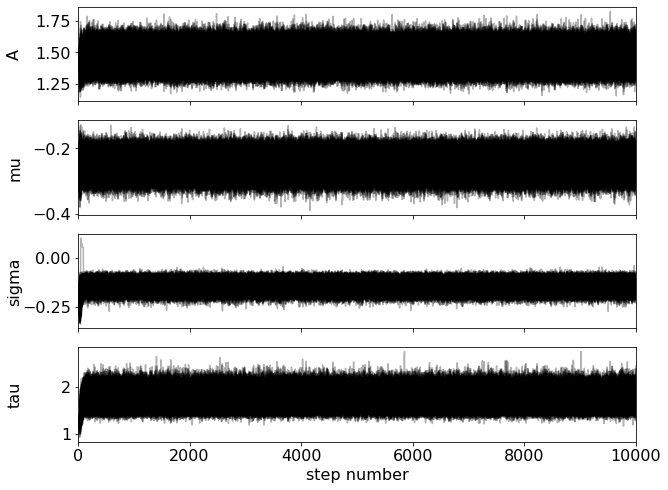

In [96]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["A","mu","sigma","tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [92]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(316500, 4)


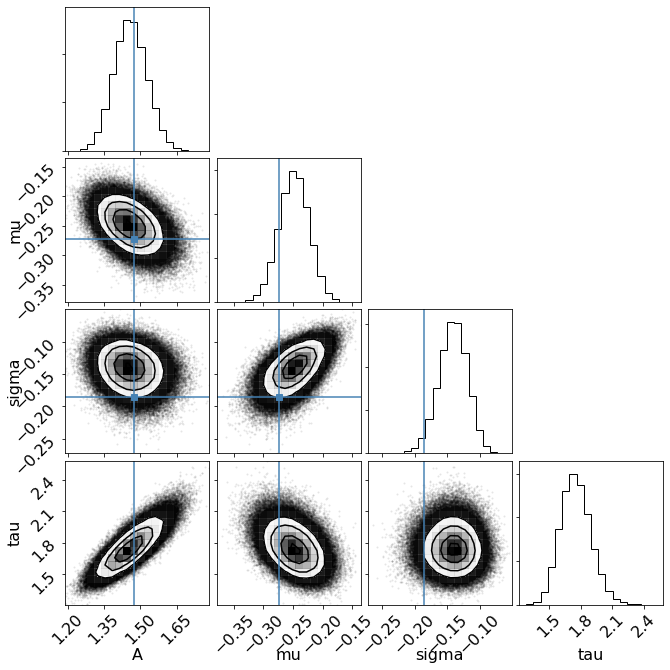

In [93]:
#truths=[3,0,.05,np.log(2.85) for jackman model
fig = corner.corner(
    flat_samples, labels=labels, truths=[amp_i,mu_i,sigma_i,np.log(tau_i)]
);

In [94]:
print("Mean acceptance fraction: {0:.3f}"
.format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.594


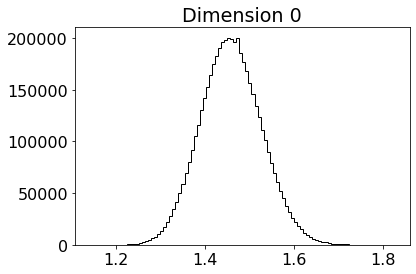

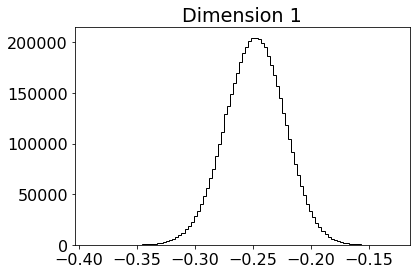

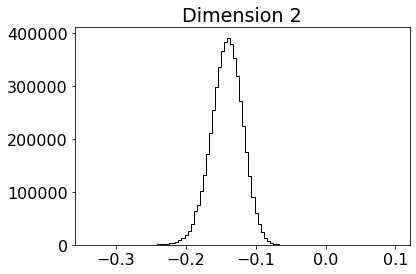

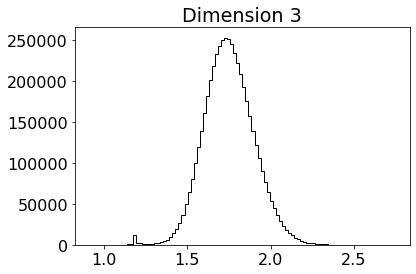

In [95]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))
plt.show()

In [97]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'Relative Flux')

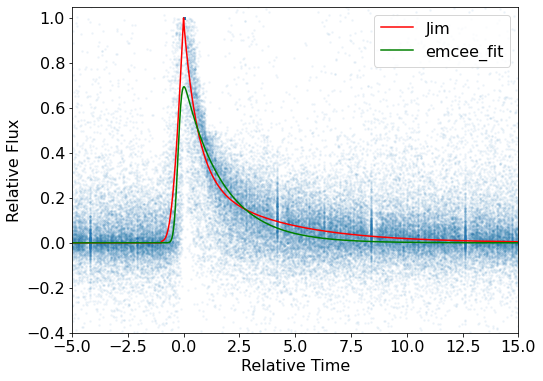

In [14]:
plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(time[ns_all],jim_model[ns_all],color='red',label='Jim')
plt.plot(time[ns_all],ModifiedGaussian(time,1.457,-0.248,-0.141,1.744)[ns_all],label='emcee_fit',color='green')
plt.scatter(time[ns_all],flux[ns_all],alpha=0.05,s=10,marker='.')
#plt.xlim(-4,5)
plt.ylim(-0.4,1.05)
plt.xlim(-5,15)
plt.legend(loc='upper right')
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')